In [1]:
%reload_ext autoreload
%autoreload 2
import opt
from spice_net import *
import numpy as np
import matplotlib.pyplot as plt

#### Generate the dataset

In [6]:
# Generate N random points
N = 50
split = 0.8
pts = np.random.rand(N, 2)

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
training['x'], test['x'] = pts[:int(N*split),:], pts[int(N*split):,:]

# Generate categories with nonlinear decision boundary
b = np.random.random(1)
m = np.random.random(1)
decision_bound = lambda x: -m*x + b

mask = pts[:, 1] > decision_bound(pts[:, 0])
pos = pts[mask]
neg = pts[~mask]
training['y'] = np.vstack((mask[:int(N*split)], ~mask[:int(N*split)])).T.astype(int)
test['y'] = np.vstack((mask[int(N*split):], ~mask[int(N*split):])).astype(int), mask[int(N*split):].T.astype(int)

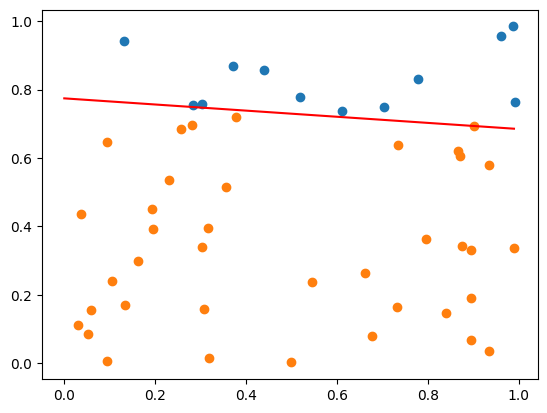

In [7]:
# Visualize dataset
plt.scatter(*pos.T)
plt.scatter(*neg.T)
xs = np.arange(0, min(x1/m,1), 0.01)
plt.plot(xs, decision_bound(xs), 'r')

#### Generate random linear and nonlinear resistive networks

In [8]:
# Parameters
nodes = 10
density = 5/(nodes-1) # limit average degree to 5
denser = 0.7
diode_thresh = 0.2 # on average each node has 1 diode
mask = np.random.uniform(0, 0.5, (nodes, nodes))
mask = mask + mask.T
con = mask < density
dense = mask < denser
diodes = mask < diode_thresh

In [9]:
# Create the linear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask
tmp = np.random.rand(nodes, nodes)
lin_network = (tmp + tmp.T) * dense

In [10]:
# Create the nonlinear network -- initialize random (symmetric) resistor values and apply 
# the connectivity mask. Then, apply the diode mask by assigning random directions to each diode.
relu_network = (tmp + tmp.T) * (dense & ~(diodes | diodes.T))
diodes_dir = tmp < tmp.T
relu_network += diodes_dir * diodes

In [11]:
# Print network statistics:
diag_mask = ~np.eye(lin_network.shape[0]).astype(bool)
print(f'Linear network edges: {np.sum(diag_mask * lin_network > 0)//2}')
print(f'ReLu network edges: {np.sum(diag_mask * np.minimum(relu_network, relu_network.T) > 0)//2}')
print(f'ReLu network diodes: {np.sum(diag_mask * (relu_network != relu_network.T))//2}')


Linear network edges: 32
ReLu network edges: 28
ReLu network diodes: 4


In [12]:
in_nodes = 3
out_nodes = 2
node_cfg = np.concatenate(([0], np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))))
node_cfg

array([ 0,  1,  0,  0,  1,  0, -1,  1,  0, -1])

#### Generate network circuits

In [271]:
lin = LinearNetwork('linear', lin_network, node_cfg)

In [351]:
minimal_mat = np.zeros((nodes, nodes))
minimal_cfg = np.zeros(nodes)
minimal_cfg[1] = 1
minimal_cfg[2] = 1
# minimal_cfg[3] = 1
minimal_cfg[4] = -1
minimal_cfg[5] = -1

# connect inputs to each output with their own tunable resistors
minimal_mat[1, 4] = 1
minimal_mat[1, 5] = 1
minimal_mat[2, 4] = 1
minimal_mat[2, 5] = 1
# minimal_mat[3, 4] = 1
# minimal_mat[3, 5] = 1


# connect both outputs to ground to complete the voltage divider
minimal_mat[4, 0] = 1
minimal_mat[5, 0] = 1
minimal_mat += minimal_mat.T

minimal_net = LinearNetwork('min', minimal_mat, minimal_cfg)

#### Train both networks

In [347]:
def train(net: LinearNetwork, xs, ys, epochs, gamma = 0.01, nu = 0.1):
    trainable_mask = np.triu(np.logical_and(net.con_mat == net.con_mat.T, net.con_mat > 0), 1)
    n = net.con_mat.shape[0]
    accuracy = np.empty(epochs+1)
    out_nodes = np.argwhere(net.node_cfg < 0).flatten()
    updates = np.empty((epochs, xs.shape[0], np.sum(trainable_mask)))

    # Calculate initial accuracy 
    pred = np.array([net.solve(x)[net.node_cfg < 0] for x in xs])
    accuracy[0] = np.count_nonzero(np.argmax(pred, axis=1) == np.argmax(ys, axis=1)) / ys.shape[0]

    for i in range(epochs):
        for j, x, y in zip(range(xs.shape[0]), xs, ys):
            free = net.solve(x)
            nudges = nu * y + (1-nu) * free[out_nodes]
            clamped = net.solve(x, nudges)

            free_rep = np.tile(free, [n, 1])
            clamped_rep = np.tile(clamped, [n,1])

            delta_free = free_rep - free_rep.T
            delta_clamped = clamped_rep - clamped_rep.T

            update = gamma * (delta_clamped**2 - delta_free**2)[trainable_mask] / net.con_mat[trainable_mask]**2 
            net.con_mat[trainable_mask] += update + update.T
            net.update(update.flatten())
            updates[i, j] = update.flatten()

        pred = np.array([net.solve(x)[net.node_cfg < 0] for x in xs])
        accuracy[i+1] = np.count_nonzero(np.argmax(pred, axis=1) == np.argmax(ys, axis=1)) / ys.shape[0]
        print(f'Epoch {i}: {accuracy[i]}')
        # print(f'Epoch {i}: {pred}')

    return net, accuracy, updates

In [275]:
augmented = np.hstack((training['x'], np.ones((training['x'].shape[0], 1))))
dset = training['x']

In [305]:
# Train linear network
trained_lin, accuracy, updates = train(lin, dset, training['y'], 10, gamma=0.01, nu=0.05)

Epoch 0: 0.8
Epoch 1: 0.8
Epoch 2: 0.8
Epoch 3: 0.8
Epoch 4: 0.8
Epoch 5: 0.8
Epoch 6: 0.8
Epoch 7: 0.8
Epoch 8: 0.8
Epoch 9: 0.8


In [352]:
trained_min, accuracy, updates = train(minimal_net, dset, training['y'], 5, gamma=0.1, nu=0.1)

Epoch 0: 0.55
Epoch 1: 1.0
Epoch 2: 1.0
Epoch 3: 1.0
Epoch 4: 1.0


In [354]:
updates.shape

(5, 40, 6)

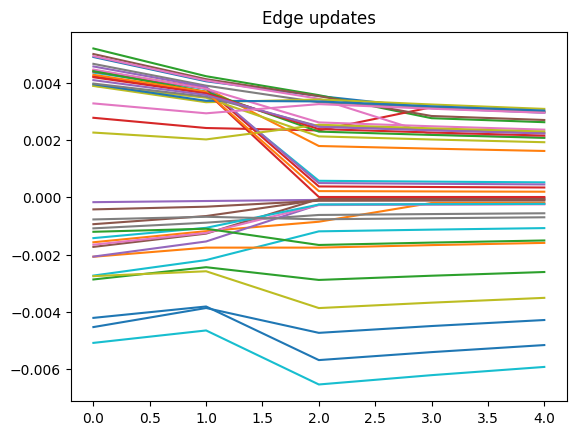

In [355]:
plt.plot(updates[:,:,0])
plt.title('Edge updates')
plt.show()

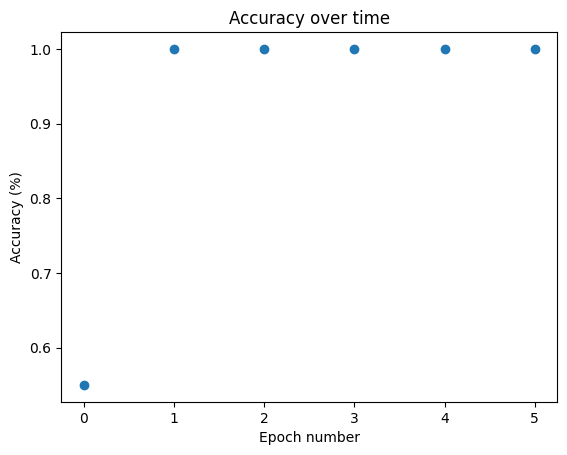

In [356]:
plt.scatter(np.arange(accuracy.size), accuracy)
plt.title('Accuracy over time')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy (%)')
plt.show()

In [323]:
print(minimal_net)

.title min
R0 0 4 1.1203120764111845
R1 0 5 1.0943411287191733
R2 1 4 1.1603948403058373
R3 1 5 0.20439033657908975
R4 2 4 1.00006759381661e-06
R5 2 5 1.1773984941774478



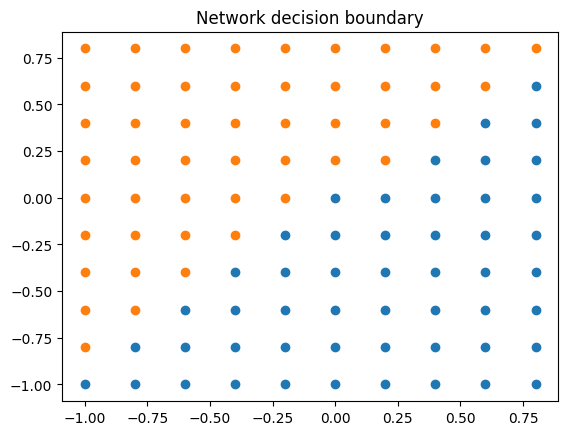

In [333]:
lh = 1
num_pts = 10
grid_set = np.array(np.meshgrid(np.arange(-lh, lh, 2*lh/num_pts), np.arange(-lh, lh, 2*lh/num_pts))).reshape(2,-1).T 
grid_augmented = np.hstack((grid_set, np.ones((grid_set.shape[0], 1))))
grid_solve = np.array([minimal_net.predict(x) for x in grid_set])
grid_outputs = np.argmax(grid_solve, axis=1)
plt.scatter(*grid_set[grid_outputs.astype(bool)].T)
plt.scatter(*grid_set[~grid_outputs.astype(bool)].T)
plt.title('Network decision boundary')
plt.show()

In [293]:
print(minimal_net)

.title min
R0 0 4 1.1174102683309561
R1 0 5 1.0594314822202742
R2 1 4 1.1249915677403783
R3 1 5 0.7740160114025268
R4 2 4 0.0
R5 2 5 1.134785062712085



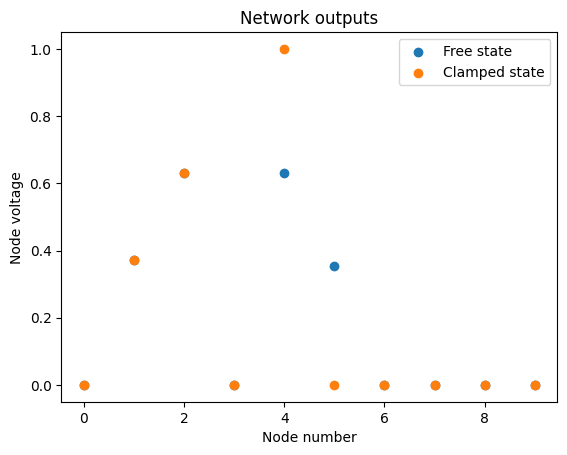

In [326]:
# Compare free and clamped results on a single input
plt.scatter(np.arange(10), minimal_net.solve(training['x'][0]))
plt.scatter(np.arange(10), minimal_net.solve(training['x'][0], training['y'][0]))
plt.title('Network outputs')
plt.xlabel('Node number')
plt.ylabel('Node voltage')
plt.legend(['Free state', 'Clamped state'])

In [297]:
minimal_net.solve(training['x'][0], training['y'][0])

array([0.        , 0.54385602, 0.77809513, 0.        , 0.58470136,
       0.40151283, 0.        , 0.        , 0.        , 0.        ])

#### Compare the networks

In [328]:
# Evaluate accuracy on training data
lin_outputs = np.array([minimal_net.predict(x) for x in dset])

In [329]:
predictions, labels = np.argmax(lin_outputs, axis=1), np.argmax(training['y'], axis=1)
lin_acc = np.sum(predictions == labels) / lin_outputs.shape[0]
# relu_acc = np.sum((relu_outputs >= 0.5) == train['y']) / lin_outputs.size
# lin_acc, relu_acc

In [330]:
lin_acc

1.0

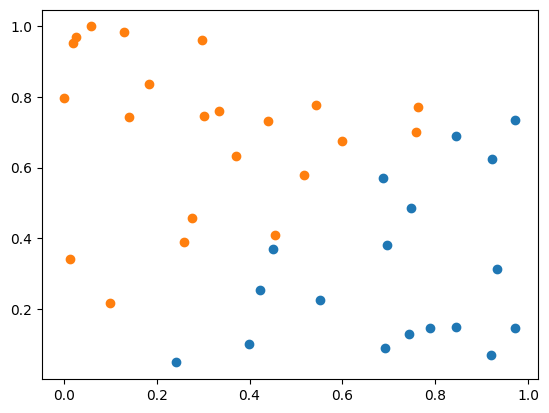

In [331]:
# Visualize the actual results
plt.scatter(*training['x'][labels.astype(bool).squeeze()].T)
plt.scatter(*training['x'][~labels.astype(bool).squeeze()].T)

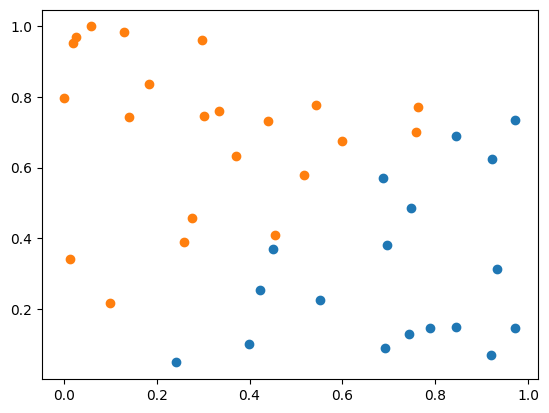

In [332]:
# Visualize linear network
plt.scatter(*training['x'][predictions.astype(bool)].T)
plt.scatter(*training['x'][~predictions.astype(bool)].T)

### Visualize Random Network Performance

In [20]:
# Generate 
eval_set = np.array(np.meshgrid(np.arange(0, 11), np.arange(0, 11))).reshape(2,-1).T / 10
eval_bias = np.hstack((eval_set, np.ones((eval_set.shape[0], 1))))
N = eval_bias.shape[0]

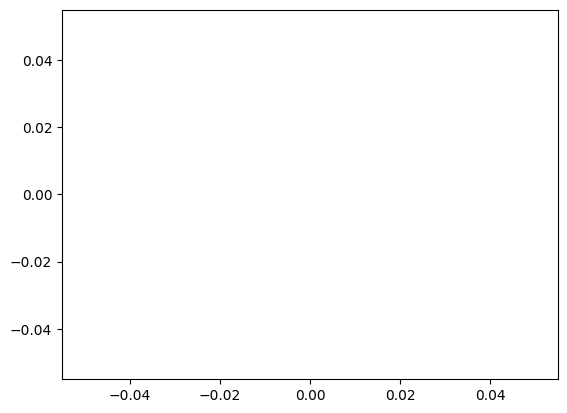

In [21]:
tmp = np.random.rand(nodes, nodes)
con_mask = (np.random.rand()  < np.random.rand(nodes, nodes))
con_mask = con_mask * con_mask.T
rand_cfg = np.concatenate(([0], np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))))

rand_net = LinearNetwork('rand', (tmp + tmp.T) * con_mask, rand_cfg)

res = np.empty((N, out_nodes))

for i in range(N):
    res[i] = rand_net.solve(eval_bias[i])[rand_cfg < 0]

plt.scatter(*eval_set[res.T[0] < res.T[1]].T)
# plt.scatter(*eval_set[res.T[0] >= res.T[1]].T)

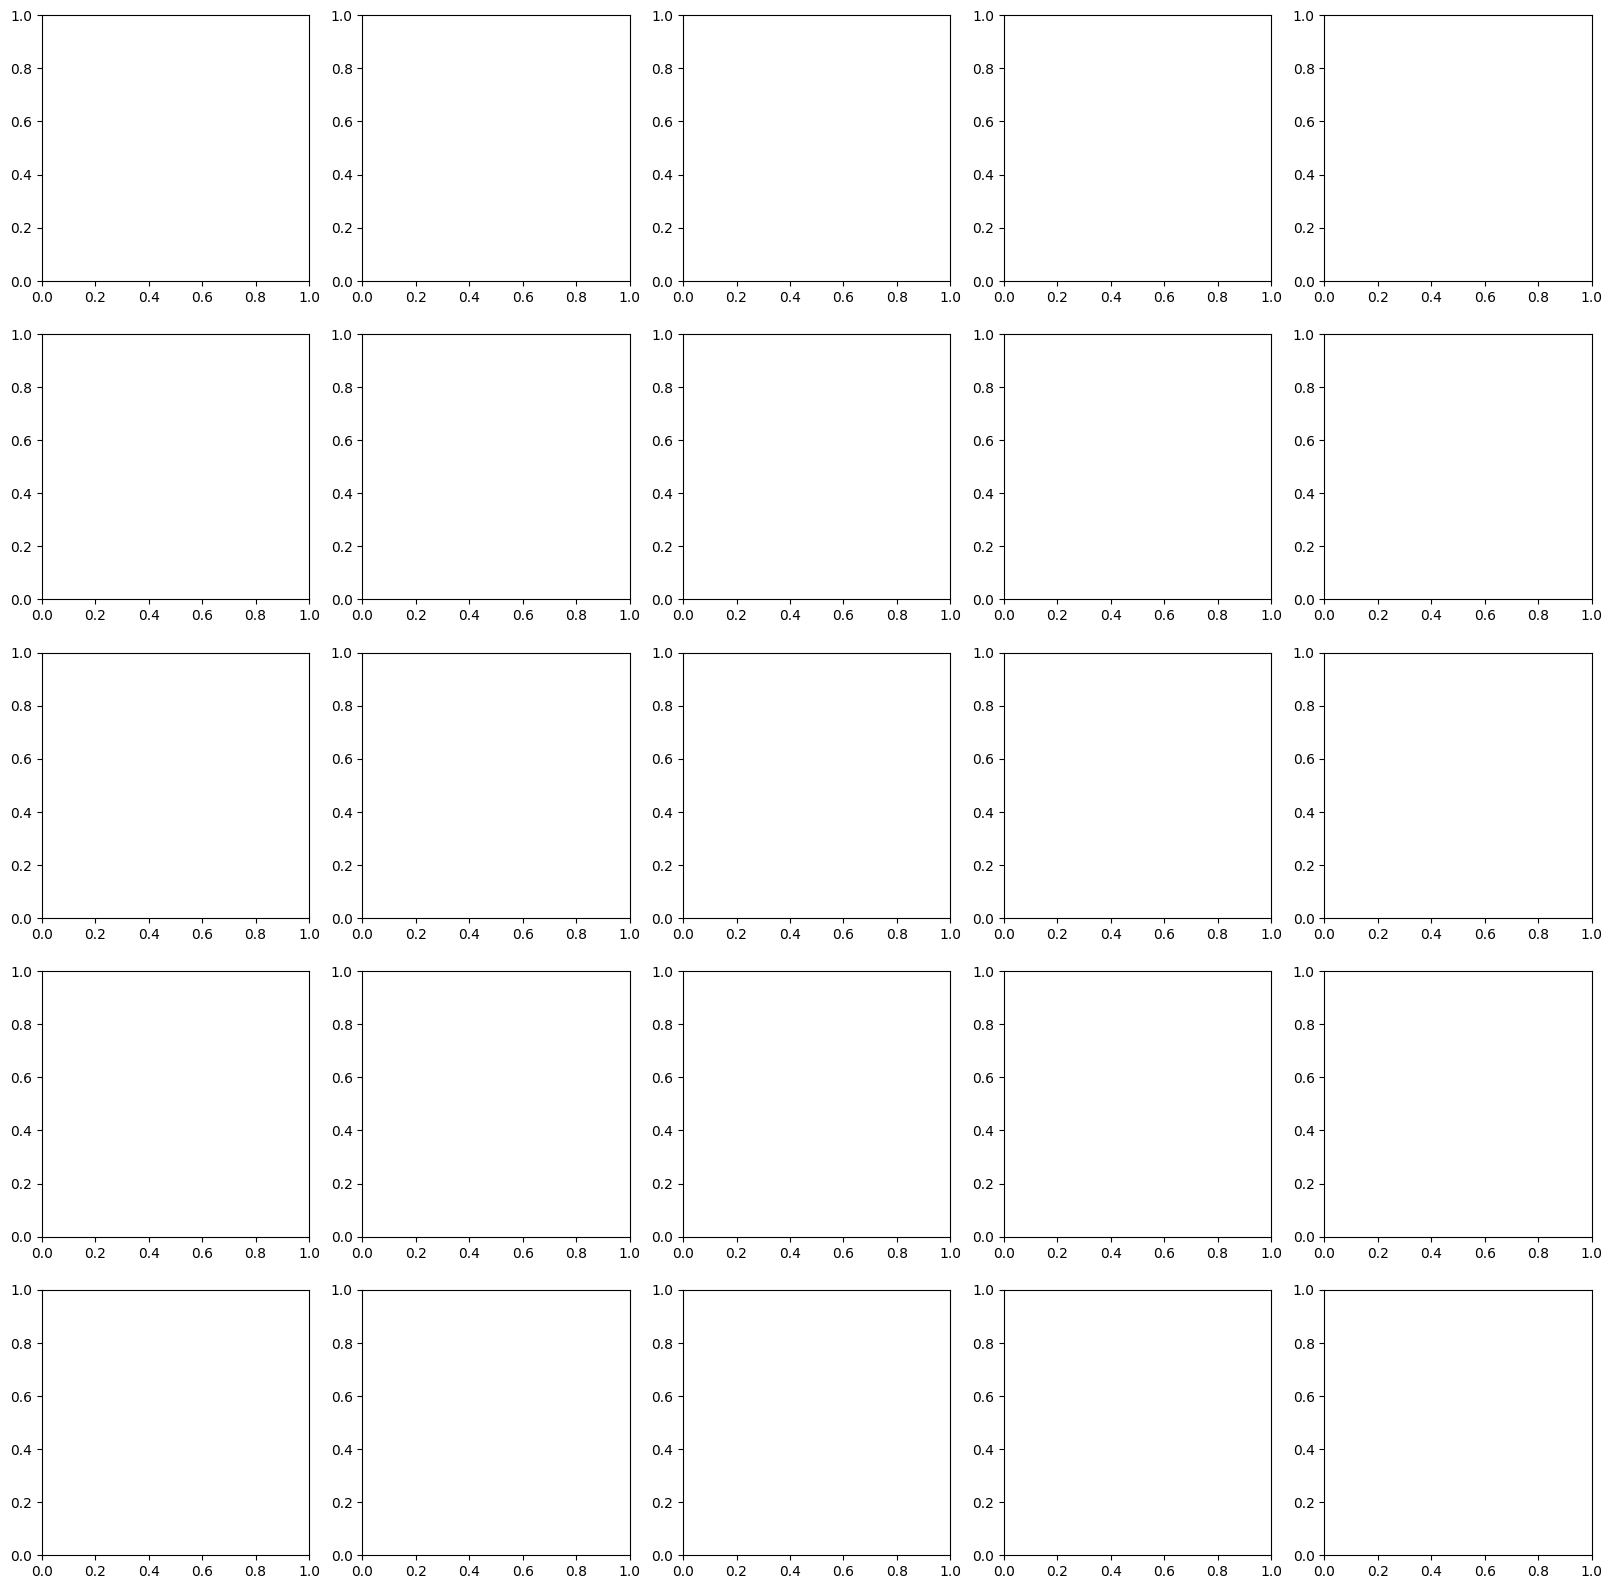

In [22]:
# Generate a ton of randomly initialized networks and see how they do
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
fig
in_nodes = 3
out_nodes = 2
nodes = 20

nodes_nums = [10, 20, 30, 50, 75]
nodes_values = {}
nets = []

for n in nodes_nums:
    nodes = n
    nodes_values[n] = []
    for row in axs:
        for subp in row:
            tmp = np.random.rand(nodes, nodes)
            con_mask = (np.random.rand()  < np.random.rand(nodes, nodes))
            con_mask = con_mask * con_mask.T
            rand_cfg = np.concatenate(([0], np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))))

            rand_net = LinearNetwork('rand', (tmp + tmp.T) * con_mask, rand_cfg)
            nets.append([(tmp + tmp.T) * con_mask, rand_cfg])

            # cm, nc = nets[j]
            # rand_net = LinearNetwork('rand', cm, nc)
            
            res = np.empty((N, out_nodes))
            for i in range(N):
                res[i] = rand_net.solve(eval_bias[i])[rand_cfg < 0]
            
            nodes_values[n].append(res)
            # # res = res[:2] - res[2:]
            # subp.scatter(*eval_set[res.T[0] < res.T[1]].T)
            # subp.scatter(*eval_set[res.T[0] > res.T[1]].T)
            # subp.scatter(*eval_set[res.T[0] == res.T[1]].T)
            # j += 1

In [ ]:
nets

In [ ]:
sus_net = LinearNetwork('sus', *nets[-1])

In [ ]:
print(sus_net)

.title sus
R0 0 2 0.349827898233006
R1 0 4 1.196368438170716
R2 0 5 0.9407957133122234
R3 0 7 0.8287327797193977
R4 0 9 1.2840057679997932
R5 1 2 1.544486651892592
R6 1 4 0.8877696926219039
R7 1 6 1.143300444686718
R8 1 7 1.2307530363836312
R9 1 8 0.7437506700329561
R10 1 9 1.1889640242577637
R11 2 5 1.3453639266543722
R12 2 6 1.0404516462294726
R13 2 8 0.8836290508469532
R14 2 9 1.701767684004634
R15 3 4 1.1097584846355968
R16 3 5 1.0304838237165077
R17 3 7 1.314204572114678
R18 4 9 1.1315105020541751
R19 5 6 1.5672275910398454
R20 5 9 0.18634147290673608
R21 6 7 1.7096438793487954
R22 6 8 0.6081549069136544
R23 6 9 0.9900999658917478
R24 7 8 0.7871534322277741
R25 7 9 1.884077569613963



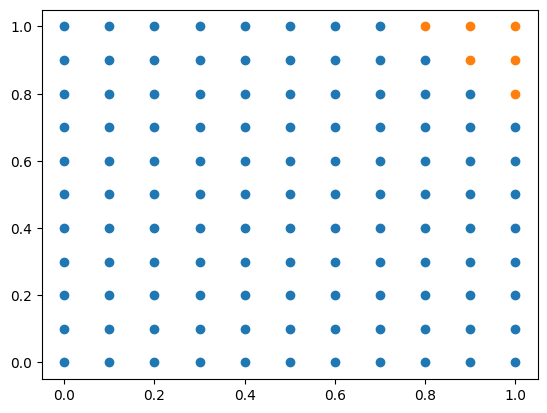

In [ ]:
res = np.empty((N, out_nodes))
for i in range(N):
    res[i] = sus_net.solve(eval_bias[i])[rand_cfg < 0]

plt.scatter(*eval_set[res.T[0] < res.T[1]].T)
plt.scatter(*eval_set[res.T[0] > res.T[1]].T)
plt.scatter(*eval_set[res.T[0] == res.T[1]].T)

In [ ]:
print(sus_net)

.title rand
R0 0 2 0.6665987627849591
R1 0 4 0.5059691368189476
R2 0 5 0.9465677974597428
R3 0 7 1.0940815828794594
R4 0 8 0.450084033992904
R5 0 9 0.5704427470068788
R6 1 2 0.8704110893388182
R7 1 3 1.0265067524102198
R8 1 7 0.990368907126467
R9 1 8 1.252337502091214
R10 1 9 1.1230684385347929
R11 2 3 0.5995202010269257
R12 2 6 1.085911880065543
R13 2 7 0.6819607654074623
R14 2 8 1.1372039446565445
R15 2 9 0.3771505415524653
R16 3 5 0.7091900818706769
R17 3 6 0.56878471972491
R18 4 5 0.9559889498484285
R19 4 6 1.331043612091639
R20 4 7 1.0882881896671344
R21 5 7 1.3021479749325762
R22 5 8 0.9651359164398519
R23 5 9 1.0477164808799522
R24 6 7 0.4934428710129847
R25 6 8 1.2954817984321436
R26 6 9 1.3321073947800977
R27 7 8 1.418903653165053
R28 8 9 0.34265837537905586

